<a href="https://colab.research.google.com/github/avantgarda/f1tenth_gym/blob/colab/colab/F1TenthGymRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning with **F1Tenth Gym** on Colab

---
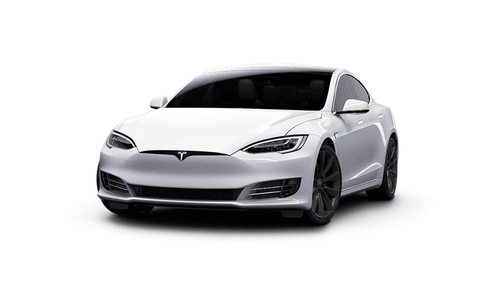

### Install Stable Baselines 3 and F1Tenth Gym
Checkout out the documentation for:
- [Stable Baselines 3](https://stable-baselines3.readthedocs.io/en/master/) the reinforcement learning library
- [F1Tenth Gym](https://f1tenth-gym.readthedocs.io/en/latest/index.html) the F1Tenth simulation environment

In [ ]:
!pip3 install pyglet==1.5.11
!pip3 install gym==0.19.0
!pip install pyyaml==5.4.1

In [ ]:
# install stable baselines 3
!echo Installing Stable Baselines 3...
!pip install stable-baselines3[extra] >/dev/null 2>&1

# install f1tenth gym
%cd /content
!echo Cloning repository...
!git clone https://github.com/avantgarda/f1tenth_gym >/dev/null 2>&1 # cloning from forked version of F1Tenth Gym repo
%cd /content/f1tenth_gym
!git checkout colab
%cd gym
!python setup.py install >/dev/null 2>&1 # installing gym package
!echo Installed F1Tenth Gym and Stable Baselines 3

### Some libraries

In [ ]:
import os
import gym
import time
import glob
import numpy as np
import stable_baselines3

from gym import spaces
from datetime import datetime

### F1Tenth Gym wrapper
**N.B.** Make sure you run this cell!

Maybe run all the other cells to the end at least once to get a feel for how this Colab notebook works before coming back here.

This cell contains a defintion of the reward function, so definitely come back and play around with it! Make sure to re-run it after making any changes.

In [ ]:
class F110_Wrapped(gym.Wrapper):
  """
  This is a wrapper for the F1Tenth Gym environment intended
  for only one car, but could be expanded to handle multi-agent scenarios
  """

  def __init__(self, env):
    super().__init__(env)

    # action space for steer and speed
    # just defines the range of values for the RL algorithm to expect
    # here we define a normalised range [-1, 1], to allow for faster training
    self.action_space = spaces.Box(low=np.array([-1.0, -1.0]), high=np.array([1.0, 1.0]), dtype=np.float)
    
    # observation space, just taking the lidar scans for now
    # the lidar scan returns 1080 different distance readings from slighlty different angles
    self.observation_space = spaces.Box(low=0.0, high=30.0, shape=(1080,), dtype=np.float)
    
    # store allowed steering/speed ranges for scaling to normalised range (for RL algorithms)
    # s is the steering, v is the velocity/speed
    self.s_min = self.env.params['s_min']
    self.s_max = self.env.params['s_max']
    self.v_min = self.env.params['v_min']
    self.v_max = self.env.params['v_max']
    self.range_s = self.s_max - self.s_min
    self.range_v = self.v_max - self.v_min

  def step(self, action):
    # the original step function returns new observations, but no useful reward
    # so here we add in our reward function too, for outputting to the RL algorithm

    # convert normalised actions (from RL algorithm) back to actual action range
    action_convert = self.convert_actions(action)
    # step forward on frame in the simulator with the chosen actions
    observation, _, done, info = self.env.step(np.array([action_convert]))
    
    ### REWARD ###

    # TODO -> do some reward engineering here and mess around with this

    # currently setting the magnitude of the car's velocity to be a positive reward
    vel_magnitude = np.linalg.norm([observation['linear_vels_x'][0], observation['linear_vels_y'][0]])
    reward = vel_magnitude

    ### OTHER EXAMPLES OF POSSIBLE REWARDS ###

    # if collisions is true, then the car has crashed
    # if observation['collisions'][0]:
    #   reward = -1000

    # just a simple counter that increments when the car completes a lap
    # reward = self.env.lap_counts[0]

    # return observations, with reward
    return observation['scans'][0], reward, bool(done), info

  def reset(self):
    # car should start off in slightly different positions to help with training
    rand_x = np.random.uniform(-1.0, 1.0)   # random x coordinate on map (within a certain range)
    rand_y = np.random.uniform(-1.0, 1.0)   # random y coordinate on map (within a certain range)
    rand_t = np.random.uniform(65.0, 125.0) # rotational position of car (in degrees)
    starting_pose = [rand_x, rand_y, np.radians(rand_t)] # convert degrees to radians for angle
    observation, _, _, _ = self.env.reset(poses=np.array([starting_pose]))
    return observation['scans'][0]  # reward, done, info can't be included in the Gym format

  def convert_actions(self, actions):
    # convert actions values from normalised range [-1, 1] to the normal steering/speed range
    steer = (((actions[0] + 1) * self.range_s) / 2) + self.s_min
    speed = (((actions[1] + 1) * self.range_v) / 2) + self.v_min
    return np.array([steer, speed], dtype=np.float)

### Map choice
Here is where you'd change the file path to chose a different map. There are other maps in the following folder:

```/content/f1tenth_gym/gym/f110_gym/envs/maps```

I'm not sure if they work yet. Basically there should be a yaml config file and a black and white map photo per map

In [ ]:
MAP_PATH = '/content/f1tenth_gym/examples/example_map' # the official repo comes with an example map in the f1tenth_gym/examples folder
MAP_IMAGE_EXTENSION = '.png'

### Training setup
Choose model and policy, check out the Stable Baselines 3 docs [here](https://stable-baselines3.readthedocs.io/en/master/guide/algos.html)

In [ ]:
# model of choice here is Promixal Policy Optimisation
# use whatever you want, but make sure to also change all other occurences of "PPO" in this notebook!
from stable_baselines3 import PPO

# create environment
env = gym.make('f110_gym:f110-v0', map=MAP_PATH, map_ext=MAP_IMAGE_EXTENSION, num_agents=1)

# wrap (modify) the environment to meet SB3 requirements
# make sure you've run the hidden F1Tenth Gym wrapper cell above!
env = F110_Wrapped(env)

# choose RL model and policy here
model = PPO('MlpPolicy', env, verbose=1)

### Training cycle
You can re-run this cell to continue training

In [ ]:
TRAIN_STEPS = pow(10, 4) # for reference, it takes about one sec per 500 steps

# train model and record time taken
start_time = time.time()
model.learn(total_timesteps=TRAIN_STEPS) # takes about one second per 500 training steps
print(f"Training time {time.time() - start_time:.2f}s")
print('Training cycle complete.')

# save model with unique timestamp
timestamp = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
model.save(f"/content/train/ppo-f110-{timestamp}")

### Evaluation
Setup of evaluation environment and rendering

**N.B.** Run this cell every time you update or train the model in the cells above

In [ ]:
# load latest trained model
trained_models = glob.glob('/content/train/*')
latest_model = max(trained_models, key=os.path.getctime)
eval_model = PPO.load(latest_model) # change the argument to a specific saved model if you wish

# create evaluation environment (same as train environment in this case)
eval_env = gym.make('f110_gym:f110-v0', map=MAP_PATH, map_ext=MAP_IMAGE_EXTENSION, num_agents=1)

# wrap evaluation environment
eval_env = F110_Wrapped(eval_env)

# open visuals in this cell, then run the evaluation steps in the next cell
eval_env.render(colab_start=True)

### Evaluation cycle
Re-run this cell and the current loaded model will simulate and render more episodes, shown on the map in the above cell output

In [ ]:
EVAL_EPISODES = 5

# simulate a few episodes and render them, click the stop button to cancel an episode
for _ in range(EVAL_EPISODES):
    try:
        obs = eval_env.reset()
        done = False
        while not done:
            # use trained model to predict some action, based off the observations
            action, _ = eval_model.predict(obs)
            obs, _, done, _ = eval_env.step(action)
            eval_env.render()
    except KeyboardInterrupt:
        pass